In [1]:
include("./MPS.jl")
using .MPSforQuantum
using TensorOperations
using LinearAlgebra
using Plots

using PyCall
sympy = pyimport("sympy")

PyObject <module 'sympy' from '/home/ryunagai/.julia/conda/3/lib/python3.8/site-packages/sympy/__init__.py'>

### Ising 相互作用(全結合) + 横磁場

シンボル変数の用意

In [2]:
N = 4
ops = ["X", "Y", "Z", "I"]
a = " "
for j = 1:4
    op = ops[j]
    for i = 1:N
        a = string(op, i)
        prog = string(op, "_ = sympy.Symbol(a)")
        prog = replace(prog, "_" => "$i")
        ex1 = Meta.parse(prog)
        #a = string(op, string(i))
        eval(ex1)
    end
end
J12 = sympy.Symbol("J12")
J23 = sympy.Symbol("J23")
J34 = sympy.Symbol("J34")
J13 = sympy.Symbol("J13")
J24 = sympy.Symbol("J24")
J14 = sympy.Symbol("J14")

PyObject J14

In [3]:
h = sympy.Symbol("h")

W1 = sympy.Matrix([[h*X1, J12*Z1, J13*Z1, J14*Z1, I1]])
W2 = sympy.Matrix([
        [I2, 0, 0, 0, 0],
        [Z2, 0, 0, 0, 0],
        [0, I2, 0, 0, 0],
        [0, 0, I2, 0, 0],
        [h*X2, J23*Z2, J24*Z2, 0, I2],
        ])
W3 = sympy.Matrix([
        [I3, 0, 0, 0, 0],
        [Z3, 0, 0, 0, 0],
        [0, I3, 0, 0, 0],
        [0, 0, I3, 0, 0],
        [h*X3, J34*Z3, 0, 0, I3],
        ])
W4 = sympy.Matrix([I4, Z4, 0, 0, h*X4])
sympy.expand(W1*W2*W3*W4)

PyObject Matrix([[I1*I2*I3*X4*h + I1*I2*I4*X3*h + I1*I2*J34*Z3*Z4 + I1*I3*I4*X2*h + I1*I3*J24*Z2*Z4 + I1*I4*J23*Z2*Z3 + I2*I3*I4*X1*h + I2*I3*J14*Z1*Z4 + I2*I4*J13*Z1*Z3 + I3*I4*J12*Z1*Z2]])

### Ising 相互作用項(NN, 一様)+横磁場

In [2]:
J = sympy.Symbol("J")

W1 = sympy.Matrix([[h*X1, J*Z1, I1]])
W2 = sympy.Matrix([
        [I2, 0, 0],
        [Z2, 0, 0],
        [h*X2, J*Z2, I2],
        ])
W3 = sympy.Matrix([
        [I3, 0, 0],
        [Z3, 0, 0],
        [h*X3, J*Z3, I3],
        ])
W4 = sympy.Matrix([I4, Z4, h*X4])
sympy.expand(W1*W2*W3*W4)

UndefVarError: UndefVarError: h not defined

In [3]:
pauliX = convert(Array{ComplexF64,2}, [0 1; 1 0])
pauliY = convert(Array{ComplexF64,2}, [0 -1*im; 1*im 0])
pauliZ = convert(Array{ComplexF64,2}, [1 0; 0 -1])
pauliI = convert(Array{ComplexF64,2}, [1 0; 0 1])
zero = convert(Array{ComplexF64,2}, [0 0; 0 0])

function Ising_NN_Hamiltonian_MPO(N_sites::Int64, h::Float64, J::Float64)
    if N_sites < 2
        error("N_sites must be larger than 1")
    end
    O = []
    push!(O, dstack((h*pauliX, J*pauliZ, pauliI)) )
    for i = 1:(N_sites-2)
        push!(O, ddstack( [(pauliI, zero, zero), (pauliZ, zero, zero), (h*pauliX, J*pauliZ, pauliI)] ))
    end
    push!(O, dstack((pauliI, pauliZ, h*pauliX)))
    return O
end

Ising_NN_Hamiltonian_MPO (generic function with 1 method)

4 site で計算

In [6]:
D = 10
N = 4
C0 = zeros(ComplexF64, 2^N)
C0 = normalize!(rand(ComplexF64, 2^N))
mps = MPS(C0, D, 'r') # convert to MPS
O = Ising_NN_Hamiltonian_MPO(N, -0.01, -1.0)

(opt_mps, hist) = iterative_ground_state_search(mps, O, D, 1)

(Any[Array{Complex{Float64},2}[[0.5025042729765014 + 0.0im -0.497483121537154 - 4.943138533351144e-20im], [0.5024837241496735 - 4.942897866641225e-18im 0.49750387575443267 - 4.943344501614827e-18im]], Array{Complex{Float64},2}[[0.5010157705364524 - 6.307508351349395e-13im 0.4990028548812244 - 5.589005125665476e-13im -3.102947086031596e-6 + 4.9960675272191695e-17im -3.0832317352156775e-6 + 7.119408917103613e-17im; -0.49849396651800193 - 1.0982309529631441e-12im -0.5014809206742062 + 2.2944447001036237e-12im -3.1499955756555472e-6 + 5.158308365374981e-16im -3.1614376538876075e-6 - 6.238433734273574e-16im], [0.5015556872576398 - 3.457968850155129e-10im -0.49841874065427955 + 3.4711605539327583e-10im 3.0996100407118756e-6 + 1.1379679404920572e-13im -3.0868479771808687e-6 - 1.144979244973024e-13im; 0.4990779997528932 - 3.4581259591734723e-10im -0.5009409163441509 + 3.4713778644795806e-10im -3.1463123622735493e-6 - 1.1580208225753258e-13im 3.1648482371785043e-6 + 1.1652232239455833e-13im]], 

In [7]:
hist

4-element Array{Any,1}:
 0.21274288494254281 + 2.949029909160572e-17im
 -3.0001500112490396 + 1.3417073023858332e-20im
  -3.000150011249039 - 5.1446352794893506e-26im
  -3.000150011249039 - 2.070728321768947e-25im

In [8]:
O_Z = []

# H = Z1 Z2 Z3 Z4 の期待値をとる
function pauliZ_measurement_MPO(N_sites::Int64)
    if N_sites < 2
        error("N_sites must be larger than 1")
    end
    O_Z = []
    push!(O_Z, dstack((pauliZ,)))
    for i = 1:(N_sites-2)
        push!(O_Z, ddstack( [(pauliZ,)] ) )
    end
    push!(O_Z, dstack( (pauliZ,) ))
    return O_Z
end

# H = Z1 + Z2 + Z3 + Z4
# 個々の量子ビットをpuli Z測定した値の和: magnetization に対応?
# Ising model では常にゼロ
function pauliZ_measurement_MPO_2(N_sites::Int64)
    if N_sites < 2
        error("N_sites must be larger than 1")
    end
    O_Z = []
    push!(O_Z, dstack((pauliZ, pauliI)))
    for i = 1:(N_sites-2)
        push!(O_Z, ddstack( [(pauliI, zero), (pauliZ, pauliI)] ) )
    end
    push!(O_Z, dstack( (pauliI, pauliZ) ))
    return O_Z
end

O_Z = pauliZ_measurement_MPO(N)
expectation(opt_mps, O_Z)

0.9998749903162422 - 2.5849394142282115e-26im

$h<<J$ レジームで計算した基底状態は$\frac{1}{\sqrt{2}} (|0000\rangle + |1111\rangle)$

In [9]:
print(restore(opt_mps, 0), '\n', restore(opt_mps, 15))

0.7070846797414565 - 8.408611900936381e-13im
0.7070846789296906 - 8.408658908767969e-13im

pauli Z測定の期待値を通して相転移を見る

In [10]:
function Ising_phase_transition(N_sites::Int64, D::Int64, h::Float64, J::Float64)
    C0 = zeros(ComplexF64, 2^N_sites)
    C0 = normalize!(rand(ComplexF64, 2^N_sites))
    mps = MPS(C0, D, 'r') # convert to MPS
    O = Ising_NN_Hamiltonian_MPO(N_sites, h, J)
    (opt_mps, hist) = iterative_ground_state_search(mps, O, D, 1)
    O_Z = pauliZ_measurement_MPO(N_sites)
    mag_z = expectation(opt_mps, O_Z)
    return mag_z
end

Ising_phase_transition (generic function with 1 method)

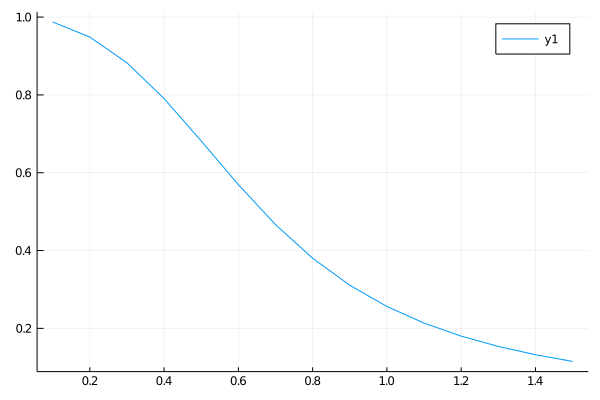

In [11]:
N = 4
D = 30
J = -1.0
measZ_list_MPS = []
h_list = []
for h = -0.1:-0.1:-1.5
    meas_z = Ising_phase_transition(N, D, h, J)
    push!(measZ_list_MPS, meas_z.re)
    push!(h_list, -h)
end

plot(h_list, measZ_list_MPS)

同様の相転移を古典計算で確認

In [12]:
function td(x::Array, y::Array)
    lx = size(x)
    ly = size(y)
    res = zeros(lx[1] * ly[1], lx[2] * ly[2])
    for i in 1:lx[1]
        for j in 1:lx[2]
            res[ (1+(i-1)*ly[1]):(ly[1]+(i-1)*ly[1]), (1+(j-1)*ly[2]):(ly[2]+(j-1)*ly[2]) ] = x[i,j] * y
        end
    end
    return res
end

function Ising_NN_Hamiltonian(h, J)
    H = J*(td(td(td(pauliZ, pauliZ), pauliI), pauliI) + td(td(td(pauliI, pauliZ), pauliZ), pauliI) + td(td(td(pauliI, pauliI), pauliZ), pauliZ))
    H += h*(td(td(td(pauliX, pauliI), pauliI), pauliI) + td(td(td(pauliI, pauliX), pauliI), pauliI))
    H += h*(td(td(td(pauliI, pauliI), pauliX), pauliI) + td(td(td(pauliI, pauliI), pauliI), pauliX))
    return H
end

function pauliZ_measure()
    measZ = td(td(td(pauliZ, pauliZ), pauliZ), pauliZ)
    return measZ
end

pauliZ_measure (generic function with 1 method)

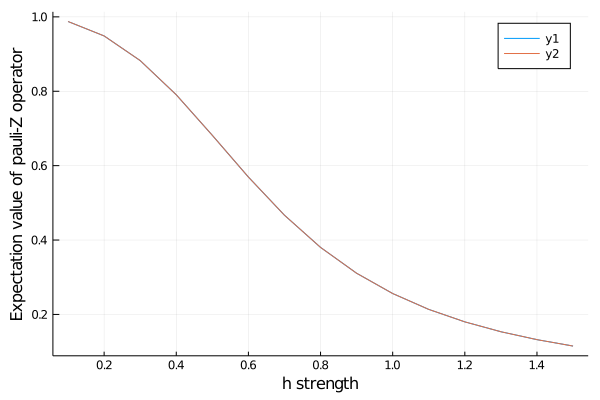

In [13]:
expc_list = []
h_list = []
for h = -0.1:-0.1:-1.5
    H = Ising_NN_Hamiltonian(h, -1.0)
    vec = eigvecs(H)[:, 1]
    measZ = pauliZ_measure()
    expc = transpose(vec) * measZ * vec
    push!(expc_list, expc)
    push!(h_list, -h)
end
plot!(h_list, expc_list)
xlabel!("h strength")
ylabel!("Expectation value of pauli-Z operator")

もっと大きな規模で

In [18]:
D = 10
N = 50
mps = init_rand_MPS(N, D, 'r') # convert to MPS
O = Ising_NN_Hamiltonian_MPO(N, -1.0, -1.0)

(opt_mps, hist) = iterative_ground_state_search(mps, O, D, 1)

(Any[Array{Complex{Float64},2}[[0.6798925482632523 + 0.0im -0.19433380293974958 + 2.80628432731184e-20im], [0.6798613079671703 + 1.6421168080931103e-19im 0.1943427327693122 + 8.752932163235195e-20im]], Array{Complex{Float64},2}[[0.6748089418345805 + 2.122090584130704e-14im -0.21127878629405084 + 5.685538232259022e-14im -0.004954976456177065 + 5.851684487969189e-13im -0.0009042064448714957 - 4.002586089631651e-13im; -0.5951171384685826 + 2.7334621543433125e-12im 0.3801459137531892 + 7.229048759770894e-12im -0.033704755130600304 + 7.446957871417469e-11im -0.012548448190093337 - 5.0938632958800395e-11im], [0.674759176426438 + 5.666879586316143e-13im 0.21129002732271193 + 1.273592711107224e-12im 0.004955565391796641 + 1.9300707112111167e-11im -0.0009042428656831533 - 1.3166770637639035e-11im; 0.5951405596471264 + 3.252201206243874e-12im 0.3801911957372363 - 5.039278351402153e-12im -0.03370652994957683 - 2.0175940218080347e-10im 0.012547528556629856 + 1.3732373713314974e-10im]], Array{Compl

In [19]:
hist

50-element Array{Any,1}:
  -49.72035443508592 - 1.7763568394002505e-15im
  -63.29725491657929 + 2.9986837429026123e-15im
  -63.29725491657925 + 2.9373403057601713e-15im
 -63.297254916579206 + 3.2458155654527197e-15im
 -63.297820463701356 + 2.775988620176703e-15im
  -63.29868021323603 + 2.5872511720136647e-15im
 -63.298749147914016 + 2.218035379246197e-15im
  -63.29885765752198 + 2.241497704891692e-15im
  -63.29887818430579 + 2.285918494926383e-15im
   -63.2988889699942 + 2.5890628201880784e-15im
 -63.298934514787916 + 2.7735491097783352e-15im
 -63.298953055396844 + 2.8156756253969193e-15im
 -63.299073471131145 + 2.609450473963397e-15im
                     ⋮
 -63.301137546148404 + 6.395930698689608e-16im
 -63.301156026685746 + 3.2296496330396554e-16im
  -63.30116549211016 + 3.043404741954688e-16im
  -63.30117629753748 + 3.4051229238521015e-16im
  -63.30118280774356 + 2.7060143167083485e-16im
  -63.30118478152899 - 4.303285674101731e-17im
  -63.30118513167209 + 5.2377864161010795e-17im


### J1J2 model

$H = \sum_{<i,j>} J_1 (\sigma^x_i \sigma^x_{j}+\sigma^y_i \sigma^y_{j}+\sigma^z_i \sigma^z_{j}) + \sum_{<<i,j>>} J_2 (\sigma^x_i \sigma^x_{j}+\sigma^y_i \sigma^y_{j}+\sigma^z_i \sigma^z_{j})$

In [4]:
L = 4
J1_term = Set()
for i in 1:L
    for j in 1:(L-1)
        row = 1 + 4*(i-1)
        push!(J1_term, (row + j - 1, row + j))
        col = i
        push!(J1_term, (col + 4*(j - 1), col + 4 + 4*(j - 1)))
    end
end

J2_term = Set()
for i in 1:(L-1)
    for j in 1:(L-1)
        row = 1 + 4*(i-1)
        push!(J2_term, (row + (j - 1), row + (j - 1) + 5))
        push!(J2_term, (row + j, row + j + 3))
    end
end

In [11]:
L = 4
j1 = 1
j2 = 0.5
N = L^2
max_distance = L + 1
MPO_L = 3*(max_distance + 2)

function push_N(arr::Array{Any,1}, op::Array{Complex{Float64},2}, N::Int64)
    arr_ = copy(arr)
    for i in 1:N
        push!(arr_, op)
    end
    return arr_
end

function j1j2_2D_Hamiltonian_MPO(L::Int64, j1::Float64, j2::Float64)
    N = L^2
    max_distance = L + 1
    MPO_L = 3*(max_distance + 2)
    O = []
    first_MPO = []
    (pauliX, pauliY, pauliZ, pauliI) = pauli()
    zero = pauli_zero()
    ops = [pauliX, pauliY, pauliZ]
    for op in ops
        push!(first_MPO, zero)
        for k in 1:max_distance
            if (1, 1 + k) in J1_term
                push!(first_MPO, op*j1)
            elseif (1, 1 + k) in J2_term
                push!(first_MPO, op*j2)
            else
                push!(first_MPO, zero)
            end
        end
        push!(first_MPO, zero)
    end
    first_MPO_tuple = Tuple(first_MPO)
    push!(O, dstack(first_MPO_tuple))

    for site in 1:N-2
        mid_MPO = []
        for i in 1:length(ops)
            for row in 1:(max_distance + 2)
                tmp_row = []
                for j in 1:(i-1) # fill zero
                    tmp_row = push_N(tmp_row, zero, max_distance + 2)
                end

                if row == 1
                    push!(tmp_row, pauliI)
                    tmp_row = push_N(tmp_row, zero, max_distance + 1)
                elseif row == 2
                    push!(tmp_row, ops[i])
                    tmp_row = push_N(tmp_row, zero, max_distance + 1)
                elseif row == (max_distance + 2)
                    push!(tmp_row, zero)
                    for k in 1:max_distance
                        if (site, site + k) in J1_term
                            push!(tmp_row, j1*ops[i])
                        elseif (site, site + k) in J1_term
                            push!(tmp_row, j2*ops[i])
                        else
                            push!(tmp_row, zero)
                        end
                    end
                    push!(tmp_row, zero)
                else
                    tmp_row = push_N(tmp_row, zero, row - 2)
                    push!(tmp_row, pauliI)
                    tmp_row = push_N(tmp_row, zero, max_distance + 1 - (row - 2))
                end
                for j in 1:(3-i) # fill zero
                    tmp_row = push_N(tmp_row, zero, max_distance + 2)
                end
                tmp_row_tuple = Tuple(tmp_row)
                push!(mid_MPO, tmp_row_tuple)
            end
        end
        push!(O, ddstack(mid_MPO))
    end

    last_MPO = []
    for op in ops
        push!(last_MPO, pauliI)
        push!(last_MPO, op)
        last_MPO = push_N(last_MPO, zero, max_distance)
    end
    last_MPO_tuple = Tuple(last_MPO)
    push!(O, dstack(last_MPO_tuple))
    return O
end

j1j2_2D_Hamiltonian_MPO (generic function with 1 method)

In [12]:
D = 10
L = 4
j1 = 1.0
j2 = 0.5

mps = init_rand_MPS(N, D, 'r') # convert to MPS
O = j1j2_2D_Hamiltonian_MPO(L, j1, j2)
(opt_mps, hist) = iterative_ground_state_search(mps, O, D, 1)

(Any[Array{Complex{Float64},2}[[0.7045936935348602 + 0.0im 0.28721491690989837 + 6.03447299965122e-17im], [-0.3151860511487127 - 0.23053830618447704im 0.4182836796241328 + 0.3059475844622945im]], Array{Complex{Float64},2}[[0.3439624591079058 - 0.3188539633636045im 0.10698637282983255 - 0.025579420554753048im -0.02420755359615895 - 0.06361556230230957im -0.12794227755672227 + 0.06358243087859886im; -0.4573210104229033 + 0.4263523445757467im 0.04203308298191431 + 0.27735510074355185im -0.1753658356532932 - 0.28128362466716983im 0.0044300862782530905 + 0.022225183894403096im], [0.8402283986442901 - 0.09983916424641776im -0.0491466153677552 - 0.021917630443853336im 0.00518614223886351 - 0.13379287249466698im 0.07762058109936311 + 0.00876997032664604im; 0.34416636699396724 - 0.03944695409467387im -0.26863890592302325 + 0.44070472578720143im -0.02425600423047923 + 0.1717713186697482im -0.015422159685222217 + 0.057233305961310724im]], Array{Complex{Float64},2}[[0.765126485902734 - 0.125116452

In [13]:
hist

16-element Array{Any,1}:
  2.356783702395711 + 2.7755575615628914e-17im
 -4.328427124746204 + 3.2959746043559335e-16im
   -4.3284271247462 + 4.793259204382235e-16im
 -4.328427124746199 + 2.7687414494770665e-17im
 -4.328427124746194 - 3.1513171511624974e-16im
 -4.328427124746196 - 4.0947352784263754e-17im
   -4.3284271247462 - 1.2761065684114362e-16im
 -4.328427124746199 + 7.653780648919563e-17im
 -4.328427124746204 - 2.0971135463995527e-16im
 -4.328427124746199 - 1.6020757122526382e-18im
 -4.328427124746202 - 7.002005254249709e-16im
 -4.328427124746199 - 4.688345690296157e-17im
 -4.328427124746192 - 1.26450581254472e-16im
   -4.3284271247462 - 2.1384252998800882e-16im
 -4.328427124746202 + 1.4858910877163725e-16im
 -4.328427124746199 - 2.408437180155406e-16im

In [60]:
mid_MPO = [(pauliI, zero, zero, zero, zero, zero, zero, zero, zero, zero, zero, zero),
    (pauliX, zero, zero, zero, zero, zero, zero, zero, zero, zero, zero, zero), 
    (zero, pauliI, zero, zero, zero, zero, zero, zero, zero, zero, zero, zero), 
    (zero, j1*pauliX, j2*pauliX, pauliI, zero, zero, zero, zero, zero, zero, zero, zero),
    (zero, zero, zero, zero, pauliI, zero, zero, zero, zero, zero, zero, zero),
    (zero, zero, zero, zero, pauliY, zero, zero, zero, zero, zero, zero, zero),
    (zero, zero, zero, zero, zero, pauliI, zero, zero, zero, zero, zero, zero),
    (zero, zero, zero, zero, zero, j1*pauliY, j2*pauliY, pauliI, zero, zero, zero, zero),
    (zero, zero, zero, zero, zero, zero, zero, zero, pauliI, zero, zero, zero),
    (zero, zero, zero, zero, zero, zero, zero, zero, pauliZ, zero, zero, zero),
    (zero, zero, zero, zero, zero, zero, zero, zero, zero, pauliI, zero, zero),
    (zero, zero, zero, zero, zero, zero, zero, zero, zero, j1*pauliZ, j2*pauliZ, pauliI)] 

push!(O, dstack((zero, j1*pauliX, j2*pauliX, pauliI, zero, j1*pauliY, j2*pauliY, pauliI, zero, j1*pauliZ, j2*pauliZ, pauliI)) )
for i = 1:N-2
    push!(O, ddstack(mid_MPO))
end
push!(O, dstack((pauliI, pauliX, zero, zero, pauliI, pauliY, zero, zero, pauliI, pauliZ, zero, zero)))

17-element Array{Any,1}:
 Complex{Float64}[0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im]

Complex{Float64}[0.0 + 0.0im 1.0 + 0.0im; 1.0 + 0.0im 0.0 + 0.0im]

Complex{Float64}[0.0 + 0.0im 0.5 + 0.0im; 0.5 + 0.0im 0.0 + 0.0im]

...

Complex{Float64}[1.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im -1.0 + 0.0im]

Complex{Float64}[0.5 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im -0.5 + 0.0im]

Complex{Float64}[0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im]
 Complex{Float64}[0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im]

Complex{Float64}[0.0 + 0.0im 1.0 + 0.0im; 1.0 + 0.0im 0.0 + 0.0im]

Complex{Float64}[0.0 + 0.0im 0.5 + 0.0im; 0.5 + 0.0im 0.0 + 0.0im]

...

Complex{Float64}[1.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im -1.0 + 0.0im]

Complex{Float64}[0.5 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im -0.5 + 0.0im]

Complex{Float64}[1.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 1.0 + 0.0im]
 Complex{Float64}[1.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 1.0 + 0.0im]

Complex{Float64}[0.0 + 0.0im 1.0 + 0.0im; 1.0 + 0.0im 0.0 + 0.0im]

Complex{

(Any[Array{Complex{Float64},2}[[0.02695038404993947 + 0.016086614651361023im -0.4701157208004061 - 0.2806108598693105im], [0.8359671738876949 + 0.0im 0.020555685115332963 + 0.0im]], Array{Complex{Float64},2}[[0.3222261831752922 + 0.8857242247609809im -0.004881041715452988 - 0.01125294307884915im -0.02982677958366048 - 0.051308780621374395im 1.6284716630732277e-16 + 9.150666335777657e-17im; 0.012692192669086947 + 0.034887861692574115im 2.4836361266211693e-16 + 2.167862243884766e-16im 0.002488575973353273 + 0.004280911330647174im -0.05873500327610394 - 0.0011249565804398356im], [-0.02743220594652914 - 0.022353843744149664im -0.26524790816469557 - 0.19072641518931963im 0.0019489135431753248 + 0.0010801613527799308im -2.3107058801097313e-18 + 4.1565600787663026e-17im; 0.7665379229791712 + 0.6246332864241047im 5.997806418189811e-16 + 5.273559366969494e-16im 0.11535440846133933 + 0.0639337616228039im 0.0019151800315657965 - 0.0010939775877965im]], Array{Complex{Float64},2}[[0.005216923900185

In [42]:
hist

10-element Array{Any,1}:
   4.53564159467768 - 2.220446049250313e-16im
 -0.324148481609576 + 2.3245294578089215e-16im
 -5.823706043321047 + 1.1102230246251565e-16im
 -6.709049769721576 + 1.1102230246251565e-16im
 -6.709049769721587 - 4.440892098500626e-16im
 -6.709049769721581 - 4.440892098500626e-16im
 -6.709049769721577 + 4.440892098500626e-16im
 -6.709049769721576 + 0.0im
 -6.709049769721576 + 0.0im
 -6.709049769721569 - 4.440892098500626e-16im